In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [440]:
from fastai import *
from fastai.collab import *
from fastai.tabular import *

import seaborn as sns

Fijo los random seeds

In [4]:
torch.manual_seed(123)
torch.cuda.manual_seed(123)
np.random.seed(123)
random.seed(123)

In [5]:
import warnings
warnings.filterwarnings('ignore')

### Algunas funciones (no tan) útiles

In [6]:
class EarlyStoppingFede(callbacks.TrackerCallback):
    valid_track = []
    "A `TrackerCallback` that terminates training when monitored quantity stops improving."
    def __init__(self, learn:Learner, monitor:str='valid_loss', mode:str='auto', min_delta:int=0, patience:int=0):
        super().__init__(learn, monitor=monitor, mode=mode)
        self.min_delta,self.patience = min_delta,patience
        if self.operator == np.less:  self.min_delta *= -1

    def on_train_begin(self, **kwargs:Any)->None:
        "Initialize inner arguments."
        self.wait = 0
        self.valid_track = []
        super().on_train_begin(**kwargs)

    def on_epoch_end(self, epoch, **kwargs:Any)->None:
        "Compare the value monitored to its best score and maybe stop training."
        current = self.get_monitor_value()
        if current is None: return
        self.valid_track.append(current)
        print("")
        print("current: ", current)
        print("current - delta: ", current - self.min_delta)
        print("best: ", self.best)
        if self.operator(current - self.min_delta, self.best):
            self.best,self.wait = current,0
            print("Esto viene bien...")
        else:
            self.wait += 1
            print("Hmmmm... sigamos un poco...")
            if self.wait > self.patience:
                print(f'Epoch {epoch}: early stopping')
                print("Bueno, ya!")
                return {"stop_training":True}
            
    def on_train_end(self, **kwargs:Any)->None:
        "Useful for cleaning up things and saving files/models."
        print(" ")
        plt.plot(self.valid_track)
        plt.grid()
        plt.xlabel("Epoch")
        plt.ylabel("Validation loss")
        print(self.valid_track)

In [7]:
class TestCallback(Callback):
    def __init__(self, learn: Learner):
        super().__init__()
        self.learn = learn
    
    def on_train_begin(self, **kwargs:Any)->None:
        super().on_train_begin(**kwargs)
        self.n_iters = 0
        #pdb.set_trace()
        
    def on_epoch_end(self, epoch, **kwargs:Any)->None:
        self.n_iters += 1
        print("testCb: Fin de la epoch " ,self.n_iters)
        if self.n_iters>=10: self.learn.stop = True
            
    def on_train_end(self, **kwargs:Any)->None:
        print(" ")
        print("TestCallBack: ¡Gracias por todo! Cantidad de epochs corridas: ", self.n_iters)

In [8]:
def id_to_position(x, learner, user = False):
    """ Funcion que toma un userId o movieId y busca su posicion en la lista de classes del learner
    """
    if user:
        classes = learner.data.dataset.x.classes['userId']
    else:
        classes = learner.data.dataset.x.classes['movieId']
    try:
        res = int(np.where(classes == str(x))[0][0])
    except:
        res = None
    return res

In [492]:
def get_user_recommendations(userid, movies, learner, only_seen = False):
    
    """ Esta funcion esta hecha para calcular las recomendaciones del modelo learn_feat.
    Toma un usuario y todas las peliculas del train set y arma un DataFrame con las recomendacionies.
    Se puede modificar para que funcione con otros modelos tocando cont_names y el input del modelo.
    """
    
    cont_names = ['Documentary',
       'Musical', 'Thriller', 'Western', 'Film-Noir', 'Adventure', 'Mystery',
       'Comedy', 'Animation', 'Drama', 'War', 'Fantasy', 'Children', 'Crime',
       'Romance', 'Horror', 'Action', 'Sci-Fi', 'IMAX', 'age']
    cont_names = cont_names + ['reviews']
    arr = movies
    # Filtro las películas en el train set
    arr = arr[arr['movieId'].apply(lambda x: np.isin(learner.data.dataset.x.classes['movieId'], str(x)).sum() >0)]
    arr['movie_pos'] = [id_to_position(x, learn_feat, user = False) for x in arr['movieId']]
    arr['userId'] = [userid for i in range(len(arr))]
    arr['user_pos'] = [id_to_position(x, learn_feat, user = True) for x in arr['userId']]
    arr = arr.filter(['user_pos', 'movie_pos'] + ['userId', 'movieId'] + ['title'] + cont_names)
    
    user_movie = torch.LongTensor(arr.iloc[:,:2].values) # Las variables categoricas por un lado
    movie_feats = torch.FloatTensor(arr.iloc[:,5:].values) # Y las continuas por el otro
    
    preds = learn_feat.model(user_movie, movie_feats)
    
    arr['prediction'] = preds.detach().numpy()
    arr['movieId'] = arr['movieId'].astype(str, inplace = True)
    pred = pd.merge(arr.filter(['user', 'movieId', 'title', 'reviews', 'prediction']), 
         ratings_con_nombres[ratings_con_nombres['userId']==1].filter(['movieId', 'rating']), 
         on = 'movieId', how = 'outer')
    pred = pd.merge(pred, movies.filter(['movieId', 'genres', 'release_year']), on = 'movieId')
    pred = pred.sort_values(by = 'prediction', ascending=False).reset_index(drop = True)
    
    if only_seen: return pred.dropna()
    
    return pred

In [10]:
def is_digit(x):
    try:
        res = x.isdigit()
    except:
        res = False
    return res

In [387]:
def movie_has_genre(movieId, genre):
    try:
        res = (movies[movies['movieId']==str(movieId)][genre]!=0).values[0]
    except:
        res = False
    return res

In [388]:
def reduce_dim(weights, components = 3):
    """Reduce dimensions of embeddings"""
    
    return TSNE(components, metric = 'cosine').fit_transform(weights)

# Data

Levanto el dataset de movielens que ya tengo bajado

In [11]:
#path = Path('/home/fvadell/trabajo/recs/ml-latest-small')
path = Path('/home/fvadell/trabajo/recs/ml-latest') # Full dataset (demasiado grande)
path.ls()

[PosixPath('/home/fvadell/trabajo/recs/ml-latest/links.csv'),
 PosixPath('/home/fvadell/trabajo/recs/ml-latest/README.txt'),
 PosixPath('/home/fvadell/trabajo/recs/ml-latest/ratings.csv'),
 PosixPath('/home/fvadell/trabajo/recs/ml-latest/genome-scores.csv'),
 PosixPath('/home/fvadell/trabajo/recs/ml-latest/movies.csv'),
 PosixPath('/home/fvadell/trabajo/recs/ml-latest/genome-tags.csv'),
 PosixPath('/home/fvadell/trabajo/recs/ml-latest/tags.csv')]

In [12]:
movies = pd.read_csv(path/'movies.csv')
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [13]:
len(movies)

58098

In [14]:
#tags = pd.read_csv(path/'tags.csv')

In [15]:
#tags.head()

In [16]:
#tags[tags['movieId']==260].head()

Acá se ve la matriz de interacciones, presentada como un csv. Agrego copias de algunas columnas pero con otro data type por si necesito

In [18]:
ratings = pd.read_csv(path/'ratings.csv')
ratings = ratings[:5000000]
#ratings['y'] = ratings.rating.apply(str)
#ratings['user'] = ratings['userId'].apply(lambda x:str(int(x))).astype('category')
#ratings['item'] = ratings['movieId'].apply(lambda x:str(int(x))).astype('category')
ratings.head()

,userId,movieId,rating,timestamp
0,1,307,3.5,1256677221
1,1,481,3.5,1256677456
2,1,1091,1.5,1256677471
3,1,1257,4.5,1256677460
4,1,1449,4.5,1256677264


In [19]:
len(ratings)

5000000

Separo los genres de las películas en columnas

In [20]:
# Getting series of lists by applying split operation.
movies.genres = movies.genres.str.split('|')
# Getting distinct genre types for generating columns of genre type.
genres_columns = list(set([j for i in movies['genres'].tolist() for j in i]))
# Iterating over every list to create and fill values into columns.
for j in genres_columns:
    movies[j] = 0
for i in range(movies.shape[0]):
    for j in genres_columns:
        if(j in movies['genres'].iloc[i]):
            movies.loc[i,j] = 1
# Separting movie title and year part using split function.
split_values = movies['title'].str.split("(", n = 1, expand = True)
# setting 'movie_title' values to title part.
movies.title = split_values[0]
# creating 'release_year' column.
movies['release_year'] = split_values[1]
# Cleaning the release_year series.
movies['release_year'] = movies.release_year.str.replace(')','')
# dropping 'genre' columns as it has already been one hot encoded.
#movies.drop('genres',axis=1,inplace=True)

In [21]:
#Consigo la media de los release years
media = round(movies.loc[movies['release_year'].apply(is_digit) == True]['release_year'].astype(int).mean())

In [22]:
#Consigo el desvio de los release years
std = round(movies.loc[movies['release_year'].apply(is_digit) == True]['release_year'].astype(int).std())

In [23]:
# Cambio los valores de release_year que no son digitos por la media
movies.loc[movies['release_year'].apply(is_digit) == False, ['release_year']] = str(media)

In [24]:
# Cambio el type a int
movies['release_year']=movies['release_year'].apply(lambda x: int(x))

In [25]:
# Creo la columna 'age' que es el release_year normalizado
movies['age'] = movies['release_year'].apply(lambda x: (x-media)/std)

In [29]:
ratings_con_nombres = pd.merge(ratings, movies, on = 'movieId')

In [494]:
ratings_con_nombres['movieId'] = movies['movieId'].astype(str, inplace = True)

In [30]:
ratings_con_nombres.sort_values(by=['movieId']).reset_index(drop = True, inplace = True)

In [31]:
ratings_con_nombres.tail()

,userId,movieId,rating,timestamp,title,genres,(no genres listed),Drama,Mystery,Romance,...,Documentary,Children,Film-Noir,Horror,Thriller,War,IMAX,Adventure,release_year,age
4999995,51253,184851,4.5,1519708275,"We Are Cheerful, Happy, Talented!","[Comedy, Drama, Romance]",0,1,0,1,...,0,0,0,0,0,0,0,0,1986,-0.24
4999996,51288,112255,4.0,1455322264,Money as Debt,"[Animation, Documentary]",0,0,0,0,...,1,0,0,0,0,0,0,0,2006,0.56
4999997,51292,72833,3.0,1359408768,"Art of Travel, The","[Adventure, Drama, Romance]",0,1,0,1,...,0,0,0,0,0,0,0,1,2008,0.64
4999998,51342,149656,4.0,1451495637,Three Sisters,[Documentary],0,0,0,0,...,1,0,0,0,0,0,0,0,2012,0.80
4999999,51356,134865,3.5,1434305597,Blackie the Pirate,"[Action, Adventure, Comedy]",0,0,0,0,...,0,0,0,0,0,0,0,1,1971,-0.84


Le agrego las columnas de cantidad de reviews y rating medio

In [32]:
# c2.groupby(['idempresa'], as_index=False).agg({'count': 'sum', 'score_ponderado': 'sum'})
# df[['source','sent']].groupby('source').agg(['count','mean'])
m = ratings_con_nombres
m['reviews'] = m['movieId']
m['rating_mean'] = m['rating']
m = ratings_con_nombres.groupby(['movieId', 'title'], as_index = False)
m = m.agg({'reviews': 'size', 'rating_mean': 'mean'}).sort_values(by = 'reviews', ascending = False).reset_index(drop = True)
m.head()

,movieId,title,reviews,rating_mean
0,318,"Shawshank Redemption, The",17729,4.422246
1,356,Forrest Gump,17389,4.055840
2,296,Pulp Fiction,16647,4.178200
3,593,"Silence of the Lambs, The",15833,4.143371
4,2571,"Matrix, The",15320,4.139001


Lo junto con el data frame movies para tener también el nombre de la película y sus tag de género

In [33]:
movies = pd.merge(movies, m, on = ['movieId', 'title'])

In [490]:
movies['movieId'] = movies['movieId'].astype(str, inplace = True)

In [35]:
len(movies), len(ratings_con_nombres)

(33457, 5000000)

## Modelo Collaborative Filtering

Armo el data bunch de fastai con la matriz de interacciones. Le pedimos que arme un validation set con el 15% de los datos y que use un batchsize de 100.

In [31]:
data = CollabDataBunch.from_df(ratings[['userId','movieId','rating']], valid_pct=0.15, bs=100)

El modelo que vamos a utilizar usa Embeddings para los usuarios y para las películas. Hay que especificarle el tamaño de los embeddings que vamos a usar (100 en ambos casos) y cuántas capas lineales y de qué tamaño.

In [32]:
emb_szs = {
  "userId": 100,
  "movieId": 100,
}

layers = [50, 10, 10]

In [33]:
y_range = [0, 5.5]

In [ ]:
learn_small = collab_learner(data, emb_szs=emb_szs, 
                             use_nn = True, emb_drop= .3, 
                             layers = [50, 10, 10], 
                             y_range=y_range)

Instancio los callbacks que voy a usar

In [ ]:
early_stopping = EarlyStoppingFede(learn = learn_small, patience = 3)

In [ ]:
testCb = TestCallback(learn = learn_small)

In [ ]:
activation_stats_cb = callbacks.ActivationStats(learn_small, [learn_small.model.layers[0], learn_small.model.layers[3], learn_small.model.layers[6], learn_small.model.layers[9]])

In [ ]:
learn_small.lr_find()
learn_small.recorder.plot(suggestion=True)

In [ ]:
small_val = [0.82210755, 0.78039706, 0.76146066, 0.7520096, 0.7477327, 0.7513617, 0.762638, 0.78425294, 0.784332]

In [ ]:
learn_small.fit_one_cycle(10, 5.0E-03, callbacks = [early_stopping, testCb, activation_stats_cb])
#learn_small.fit_one_cycle(3, 6.31E-02)

Salvo el modelo

In [ ]:
learn_small.model

In [ ]:
learn_small.save("learn_small_3layers")

Cargo el modelo guardado

In [ ]:
learn_small = learn_small.load("learn_small_3layers")

learn_small.model contiene el modelo entero. Si le paso un tensor con los usuarios y películas va a llamar al forward del modelo y me va a devolver la predicción de la red.

In [ ]:
learn_small.data.dataset.x.classes

In [ ]:
learn_small.model(torch.LongTensor([1]),torch.LongTensor([1]))

In [ ]:
# Esto me muestra todos los objetos que tiene definido el modelo
# NO significa que se vayan a usar todos.
# NO significa que no se use algo más
# Para saber exactamente cómo va a ser el flujo de datos tengo que ver el forward
#learn_small.model

In [ ]:
# Para ver el forward veo primero el código de collab_learner para ver qué modelo usa
# Veo el código de collab_learner
# >> collab_learner??
# Se ve que crea un modelo de tipo EmbeddingNN
#if use_nn: model = EmbeddingNN(emb_szs=emb_szs, layers=layers, ps=ps, emb_drop=emb_drop, y_range=y_range,
#                                   use_bn=use_bn, bn_final=bn_final, **learn_kwargs)

In [ ]:
# Veo entonces si el modelo EmbeddingNN tiene definido el forward
# >> EmbeddingNN??
# Se ve que tiene definido un forward pero que llama al forward de su super que es TabularModel
#def forward(self, users:LongTensor, items:LongTensor) -> Tensor:
#        return super().forward(torch.stack([users,items], dim=1), None)

In [ ]:
# Veo si en TabularModel hay definido un forward
# >> TabularModel??
# Se ve que si existe un y_range entonces el resultado lo pasa por una sigmoid
# pero si no tene y_range simplemente devuelve el resultado de self.layers(x)
# es decir pasar el input directamente por todas las capas que tenga definidas el modelo
#def forward(self, x_cat:Tensor, x_cont:Tensor) -> Tensor:
#        if self.n_emb != 0:
#            x = [e(x_cat[:,i]) for i,e in enumerate(self.embeds)]
#            x = torch.cat(x, 1)
#            x = self.emb_drop(x)
#        if self.n_cont != 0:
#            x_cont = self.bn_cont(x_cont)
#            x = torch.cat([x, x_cont], 1) if self.n_emb != 0 else x_cont
#        x = self.layers(x)
#        if self.y_range is not None:
#            x = (self.y_range[1]-self.y_range[0]) * torch.sigmoid(x) + self.y_range[0]
#        return x

Voy a hacer la prueba de tomar los embeddings de la primer película y el primer usuario y pasarlos "a mano" por el resto de la red neuronal. Para eso tengo en cuenta la estructura del modelo.

Voy a pasar el embedding por:

emb_drop

bn_cont no lo uso porque está seteado con la primer variable en 0 (ver)

layers

sigmoid

In [ ]:
learn_small.model

In [ ]:
# u y a son los embeddings para el primer usuario y la primer pelicula respectivamente
u = learn_small.model.embeds[0](torch.LongTensor([1]))
a = learn_small.model.embeds[1](torch.LongTensor([1]))

In [ ]:
u, a

Junto los embeddings

In [ ]:
x = torch.cat([u,a],dim=1)

In [ ]:
learn_small.model.layers

In [ ]:
# Lo paso por la capa de emb_drop, layers y después aplico la sigmoid.
# Lo que consigo es la predicción
x = learn_small.model.emb_drop(x)
x = learn_small.model.layers(x)
x = (y_range[1]-y_range[0]) * torch.sigmoid(x) + y_range[0]
x

tomo el usuario con userId = 1

In [ ]:
u = learn_small.model.embeds[0](torch.LongTensor([1]))

In [ ]:
u.shape

Y la matriz entera de embeddings de películas

In [ ]:
emb_m = learn_small.model.embeds[1].weight

In [ ]:
emb_m

In [ ]:
emb_m.shape

In [ ]:
emb_m.shape[0]

In [ ]:
emb_m

In [ ]:
#Si queremos hacer una prueba de rapidez aumentando por 100 la cantidad de películas podemos correr esto
#emb_m = torch.cat([emb_m]*100)

In [ ]:
u[0]

Creo una matriz del mismo tamaño que la matriz de embeddings pero que en cada fila tenga el embeddings del usuario para el que quiero la recomendación

In [ ]:
u = u[0].repeat(emb_m.shape[0]).reshape(emb_m.shape[0], -1)

In [ ]:
u = u.float()

In [ ]:
u[0]

In [ ]:
emb_m.shape

Concateno cada vector del embedding de movies con el del usuario

In [ ]:
x = torch.cat([u,emb_m],dim=1)

In [ ]:
x.shape

Lo paso por la capa de emb_drop, layers y despues aplico la sigmoid. Lo que consigo es la predicción del rating de ese usuario para cada una de las películas

In [ ]:
# Lo paso por la capa de emb_drop, layers y después aplico la sigmoid.
# Lo que consigo es la predicción
x = learn_small.model.emb_drop(x)
x = learn_small.model.layers(x)
x = (y_range[1]-y_range[0]) * torch.sigmoid(x) + y_range[0]
x

In [ ]:
learn_small.data.dataset.x.classes

Busco los ids de películas en el dataset

In [ ]:
PELIS = learn_small.data.dataset.x.classes['movieId']

In [ ]:
PELIS

In [ ]:
len(PELIS)

Le agrego a cada película su rating y armo un ranking de las que mejor rating predicho tienen.

In [ ]:
# Armo el top de las pelis con mayor predicción de ranking
top = sorted([(PELIS[i],round(n[0],2) ) for i,n in enumerate(x.tolist())],key=lambda x:x[1],reverse=True )
top[:10]

In [ ]:
top_df = pd.DataFrame(top)

In [ ]:
top_df.columns = ['movieId', 'prediction']

In [ ]:
top_df['movieId']=top_df['movieId'].astype(str)

In [ ]:
movies['movieId']=movies['movieId'].astype(str)

In [ ]:
top_df = pd.merge(top_df, movies, on = 'movieId')

In [ ]:
top_df.head()

In [ ]:
ratings_con_nombres['movieId']=ratings_con_nombres['movieId'].astype(str)

In [ ]:
movies_for_user = ratings_con_nombres[ratings_con_nombres['userId']==1]

In [ ]:
movies_for_user['movieId']=movies_for_user['movieId'].astype(str)

In [ ]:
a = pd.merge(movies_for_user, top_df, on = 'movieId', how = 'outer').sort_values(by = 'prediction', ascending = False).reset_index(drop = True)

In [ ]:
ratings_con_nombres[ratings_con_nombres['userId']==1].sort_values(by = 'rating', ascending = False)

#### Ranking de recomendaciones para el usuario.

Los valores que tienen NaN en user y en rating se refieren a películas que el usuario no vio

In [ ]:
a = a.filter(['userId', 'movieId', 'rating', 'prediction', 'title_y', 'genres_y'])

In [ ]:
a.head(20)

In [ ]:
a.dropna()

In [ ]:
# La información sobre la media y el desvío estándar queda en
# learner.<nombre del hook>.stats
learn_small.activation_stats.stats.shape

In [ ]:
plt.figure(figsize=(20,5))
plt.plot(learn_small.activation_stats.stats[0][0].numpy(), alpha = .8, label = '1')
plt.plot(learn_small.activation_stats.stats[0][1].numpy(), alpha = .8, label = '2')
plt.plot(learn_small.activation_stats.stats[0][2].numpy(), alpha = .8, label = '3')
plt.plot(learn_small.activation_stats.stats[0][3].numpy(), alpha = .8, label = '4')
plt.grid()
plt.legend()
plt.title("Media de las capas lineas por cada batch pasado")
plt.show()

In [ ]:
plt.figure(figsize=(20,5))
plt.plot(learn_small.activation_stats.stats[1][0].numpy(), alpha = .8, label = '1')
plt.plot(learn_small.activation_stats.stats[1][1].numpy(), alpha = .8, label = '2')
plt.plot(learn_small.activation_stats.stats[1][2].numpy(), alpha = .8, label = '3')
plt.plot(learn_small.activation_stats.stats[1][3].numpy(), alpha = .8, label = '4')
plt.legend()
plt.grid()
plt.title("Desvío de las capas lineas por cada batch pasado")
plt.show()

### Pruebo con un modelo tabular

#### y armando el databunch con la data block API de fastai

In [34]:
df = ratings
df = df.sample(frac=1).reset_index(drop=True) #Le aplico un shuffle
dep_var = 'rating'
cat_names = ['userId', 'movieId']
cont_names = []
procs = [FillMissing, Categorify, Normalize]

In [35]:
df = df.astype({'rating': 'float'})

In [36]:
df.head()

,userId,movieId,rating,timestamp,y,user,item
0,34219,800,4.0,944961725,4.0,34219,800
1,3908,6787,4.0,1416613667,4.0,3908,6787
2,25199,180,3.0,1190267269,3.0,25199,180
3,30102,1172,5.0,1386510852,5.0,30102,1172
4,44487,44555,3.0,1463508764,3.0,44487,44555


In [37]:
data = (TabularList.from_df(df, cat_names=cat_names, cont_names=cont_names, procs=procs)
                           .split_by_idx(valid_idx=range(0,10000)) #tomo las primeras 10000 filas como valid
                           .label_from_df(cols=dep_var)
                           .databunch())

In [ ]:
data.show_batch()

In [38]:
emb_szs_str = {
  "userId": 100,
  "movieId": 100,
}

In [39]:
y_range = [0, 5.5]

In [40]:
learn_tab = tabular_learner(data, 
                            layers=[50, 10, 10], 
                            emb_szs=emb_szs_str,
                            y_range = y_range,
                            metrics=rmse)

In [41]:
data.get_emb_szs({'userId':100,'movieId':100})

[(51358, 100), (33446, 100)]

In [42]:
early_stopping = EarlyStoppingFede(learn = learn_tab, patience = 1)

In [ ]:
testCb = TestCallback(learn = learn_tab)

In [ ]:
activation_stats_cb = callbacks.ActivationStats(learn_tab, [learn_tab.model.layers[0], learn_tab.model.layers[3], learn_tab.model.layers[6], learn_tab.model.layers[9]])

In [ ]:
learn_tab.fit_one_cycle(10, 5.0E-03, callbacks = [early_stopping, testCb, activation_stats_cb])

In [ ]:
tab_val = [0.8082846, 0.77753174, 0.74447626, 0.735781, 0.7415966, 0.7350267, 0.7559605, 0.77367246]

In [ ]:
learn_tab.save("learn_tab_3layers")

In [ ]:
learn_tab.model.forward??

In [ ]:
learn_tab = learn_tab.load("learn_tab_3layers")

In [ ]:
emb_m = learn_tab.model.embeds[1].weight

In [ ]:
emb_m.shape

In [ ]:
u = learn_tab.model.embeds[0](torch.LongTensor([1]))

In [ ]:
u.shape

In [ ]:
learn_tab.model #Me armó los embeddings del tamaño que le pintó

In [ ]:
u = u[0].repeat(emb_m.shape[0]).reshape(emb_m.shape[0], -1)

In [ ]:
u = u.float()

In [ ]:
x = torch.cat([u,emb_m],dim=1)

In [ ]:
x.shape

In [ ]:
# Lo paso por la capa de emb_drop, layers y después aplico la sigmoid.
# Lo que consigo es la predicción
x = learn_tab.model.emb_drop(x)
x = learn_tab.model.layers(x)
x = (y_range[1]-y_range[0]) * torch.sigmoid(x) + y_range[0]
x

In [ ]:
PELIS = learn_tab.data.dataset.x.classes['movieId']

In [ ]:
PELIS

In [ ]:
# Armo el top de las pelis con mayor predicción de ranking
top = sorted([(PELIS[i],round(n[0],2) ) for i,n in enumerate(x.tolist())],key=lambda x:x[1],reverse=True )
top[:10]

In [ ]:
top_df = pd.DataFrame(top)

In [ ]:
top_df.columns = ['movieId', 'pred']

In [ ]:
top_df.head()

In [ ]:
top_df['movieId']=top_df['movieId'].astype(str)

In [ ]:
movies['movieId']=movies['movieId'].astype(str)

In [ ]:
top_df = pd.merge(top_df, movies, on = 'movieId')

In [ ]:
top_df.head()

In [ ]:
movies_for_user = ratings_con_nombres[ratings_con_nombres['userId']==1]

In [ ]:
movies_for_user.head()

In [ ]:
top_df['movieId'] = top_df['movieId'].astype(str)

In [ ]:
movies_for_user['movieId'] = movies_for_user['movieId'].astype(str)

In [ ]:
pd.merge(movies_for_user, top_df, on = 'movieId', how = 'outer')

In [ ]:
movies_for_user['movieId'].astype(str, inplace = True)

In [ ]:
a = pd.merge(movies_for_user, top_df, on = 'movieId', how = 'outer').sort_values(by = 'pred', ascending = False).reset_index(drop = True)

In [ ]:
a.head()

In [ ]:
a = a.filter(['userId', 'movieId', 'rating', 'pred', 'title_y'])

In [ ]:
a.head()

In [ ]:
a.columns = ['userId', 'movieId', 'rating', 'pred', 'title']

In [ ]:
a.dropna()


In [ ]:
movies_for_user.head()

In [ ]:
a.head(100)

## Modelo Tabular + otras features

In [36]:
ratings_con_nombres.columns

Index(['userId', 'movieId', 'rating', 'timestamp', 'title', 'genres',
       '(no genres listed)', 'Drama', 'Mystery', 'Romance', 'Comedy', 'Sci-Fi',
       'Western', 'Animation', 'Musical', 'Crime', 'Action', 'Fantasy',
       'Documentary', 'Children', 'Film-Noir', 'Horror', 'Thriller', 'War',
       'IMAX', 'Adventure', 'release_year', 'age', 'reviews', 'rating_mean'],
      dtype='object')

In [37]:
df = ratings_con_nombres
df = df.sample(frac=1).reset_index(drop=True) #Le aplico un shuffle
dep_var = 'rating'
cat_names = ['userId', 'movieId']
# Ordenarlas alfabeticamente por las dudas
cont_names = ['Documentary', 'Musical', 'Thriller',
       'Western', 'Film-Noir', 'Adventure', 'Mystery', 'Comedy', 'Animation',
       'Drama', 'War', 'Fantasy', 'Children', 'Crime', 'Romance', 'Horror',
       'Action', 'Sci-Fi', 'IMAX', 'age']
# Agrego la cantidad de reviews y rating medio
cont_names = cont_names + ['reviews']
procs = [FillMissing, Categorify, Normalize]

In [38]:
df.head()

,userId,movieId,rating,timestamp,title,genres,(no genres listed),Drama,Mystery,Romance,...,Film-Noir,Horror,Thriller,War,IMAX,Adventure,release_year,age,reviews,rating_mean
0,49373,3404,3.0,1052287443,Titanic,"[Action, Drama]",0,1,0,0,...,0,0,0,0,0,0,1953,-1.56,3404,3.0
1,37293,74458,3.5,1469313490,Shutter Island,"[Drama, Mystery, Thriller]",0,1,1,0,...,0,0,1,0,0,0,2010,0.72,74458,3.5
2,47660,1777,2.0,942172427,"Wedding Singer, The","[Comedy, Romance]",0,0,0,1,...,0,0,0,0,0,0,1998,0.24,1777,2.0
3,9524,3429,5.0,962468296,Creature Comforts,"[Animation, Comedy]",0,0,0,0,...,0,0,0,0,0,0,1989,-0.12,3429,5.0
4,33903,912,4.0,941751781,Casablanca,"[Drama, Romance]",0,1,0,1,...,0,0,0,0,0,0,1942,-2.00,912,4.0


In [39]:
df = df.astype({'rating': 'float'})

In [57]:
batch_size = 4096*2

In [58]:
data = (TabularList.from_df(df, cat_names=cat_names, cont_names=cont_names, procs=procs)
                           .split_by_idx(valid_idx=range(0,100000)) #tomo las primeras 10000 filas como valid
                           .label_from_df(cols=dep_var)
                           .databunch(bs = batch_size))

In [59]:
# Pruebo otra cosa
#emb_szs_str = {
#  "userId": 20,
#  "movieId": 20,
#}

In [60]:
emb_szs_str = {
  "userId": 100,
  "movieId": 100,
}

In [61]:
y_range = [0, 5.5]
#layers = [50]
#layers=[50, 10, 10]
layers = [200, 100, 50, 20] #<- Esta es la mejor
#layers = [200, 100, 100, 50, 20]

In [45]:
learn_feat = tabular_learner(data, 
                            layers=layers, 
                            emb_szs=emb_szs_str,
                            y_range = y_range,
                            metrics=[rmse, mae])

In [46]:
learn_feat.model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(51339, 100)
    (1): Embedding(33249, 100)
  )
  (emb_drop): Dropout(p=0.0, inplace=False)
  (bn_cont): BatchNorm1d(21, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=221, out_features=200, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Linear(in_features=200, out_features=100, bias=True)
    (4): ReLU(inplace=True)
    (5): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Linear(in_features=100, out_features=50, bias=True)
    (7): ReLU(inplace=True)
    (8): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): Linear(in_features=50, out_features=20, bias=True)
    (10): ReLU(inplace=True)
    (11): BatchNorm1d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): Linear(i

In [47]:
early_stopping = EarlyStoppingFede(learn = learn_feat, patience = 0)

In [48]:
testCb = TestCallback(learn = learn_feat)

In [51]:
activation_stats_cb = callbacks.ActivationStats(learn_feat, [learn_feat.model.layers[0], learn_feat.model.layers[3], learn_feat.model.layers[6], learn_feat.model.layers[9], learn_feat.model.layers[12]])

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.91E-02
Min loss divided by 10: 1.10E-01


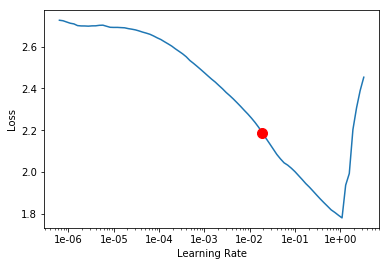

In [58]:
learn_feat.lr_find()
learn_feat.recorder.plot(suggestion = True)

In [ ]:
learn_feat.loss_func
len(ratings_con_nombres)

epoch,train_loss,valid_loss,root_mean_squared_error,mean_absolute_error,time
0,0.669447,0.700805,0.837066,0.637085,05:55
1,0.649051,0.685597,0.827938,0.628788,05:53
2,0.623181,0.667489,0.816932,0.618670,06:06
3,0.605247,0.651674,0.807197,0.610888,06:08
4,0.587977,0.642805,0.801685,0.604947,06:13
5,0.569921,0.637293,0.798232,0.602287,06:13
6,0.556197,0.634984,0.796785,0.599964,06:03



current:  0.7008046
current - delta:  0.700804591178894
best:  inf
Esto viene bien...
testCb: Fin de la epoch  1

current:  0.68559724
current - delta:  0.6855972409248352
best:  0.7008046
Esto viene bien...
testCb: Fin de la epoch  2

current:  0.6674893
current - delta:  0.6674892902374268
best:  0.68559724
Esto viene bien...
testCb: Fin de la epoch  3

current:  0.6516737
current - delta:  0.6516736745834351
best:  0.6674893
Esto viene bien...
testCb: Fin de la epoch  4

current:  0.64280534
current - delta:  0.6428053379058838
best:  0.6516737
Esto viene bien...
testCb: Fin de la epoch  5

current:  0.6372927
current - delta:  0.6372926831245422
best:  0.64280534
Esto viene bien...
testCb: Fin de la epoch  6

current:  0.63498384
current - delta:  0.6349838376045227
best:  0.6372927
Esto viene bien...
testCb: Fin de la epoch  7

current:  0.63606894
current - delta:  0.6360689401626587
best:  0.63498384
Hmmmm... sigamos un poco...
Epoch 7: early stopping
Bueno, ya!
testCb: Fin de 

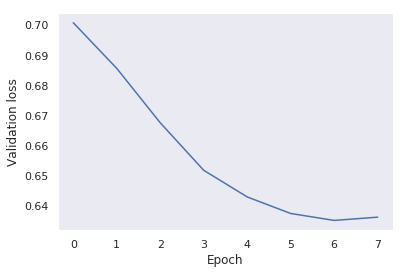

In [488]:
learn_feat.fit_one_cycle(15, max_lr=slice(5.0E-4), callbacks = [early_stopping, testCb, activation_stats_cb], wd = 1e-1)

In [ ]:
# Estos fueron los validation loss que me dieron cuando corrí por primera vez los modelos
feat_val_4l_wd = [1.6336462, 1.4850413, 1.3301895, 1.1259092, 0.9350655, 0.809925, 0.7693917, 0.7516432, 0.7440811, 0.7270105, 0.72694075, 0.7237925, 0.71411973, 0.7136541, 0.7087524, 0.7042996, 0.70322967, 0.7037794, 0.70167774, 0.7034479, 0.70354235, 0.70236206]
feat_val = [1.497502, 1.2569796, 1.0194939, 0.84688425, 0.79506433, 0.76746106, 0.75731516, 0.7520365, 0.74122566, 0.73910344, 0.7420274, 0.73805964, 0.7364563, 0.7356083, 0.7408874, 0.74903953, 0.7393274]
feat_val_4l = [2.0200536, 1.647527, 1.149215, 0.7743218, 0.7528064, 0.723357, 0.7092882, 0.70643723, 0.7073763, 0.7027935, 0.69671184, 0.69825137, 0.6999685]
feat_val_5l = [1.4140244, 1.2700337, 1.1224762, 0.9325785, 0.8421689, 0.7948672, 0.7772083, 0.75844234, 0.7481273, 0.73664397, 0.7258033, 0.72641003, 0.71947235, 0.71339095, 0.7171096, 0.7156349, 0.7207856]

#### Inicio prueba de dataset de juguete

In [ ]:
N_PELIS = 7000

In [ ]:
import numpy as np

In [ ]:
pelis = pd.DataFrame(np.random.random((20,N_PELIS))).apply(round).T #20 Filas, N_PELIS columnas y transpose al final

In [ ]:
pelis.columns = cont_names

In [ ]:
pelis = pelis.reset_index()


In [ ]:
pelis.columns = ['movieId']+cont_names

In [ ]:
pelis.head()

In [ ]:
minter = pd.DataFrame({'user':[500 for i in range(N_PELIS)],'movieId':[i for i in range(N_PELIS)]})

In [ ]:
minter.head()

In [ ]:
arr = minter.merge(pelis,on='movieId')

In [ ]:
arr.shape

In [ ]:
arr.head()

In [ ]:
user_movie = torch.LongTensor(arr.iloc[:,:2].values) # Las variables categoricas por un lado
movie_feats = torch.FloatTensor(arr.iloc[:,2:].values) # Y las continuas por el otro

In [ ]:
arr.iloc[:,:2].values

In [ ]:
user_movie.shape, movie_feats.shape

In [ ]:
user_movie

In [ ]:
movie_feats

In [ ]:
learn_feat.model(user_movie,
                movie_feats) # Se lo pasamos al modelo y conseguimos las predicciones
# Aclaro: Para usar este método reqiuere tener el DataFrame filtrado para un sólo user

#### Fin de la prueba con el DataSet de juguete

Voy a crear una matriz que tenga todas las películas (las del testset) con sus categorías y age, y le vamos a agregar un user. Esto va a ser el input del modelo para que nos haga las predicciones.

In [ ]:
movies.head()

In [ ]:
arr = movies

In [ ]:
arr.head()

Primero voy a quedarme con aquellas películas que forman parte del Train set.

In [ ]:
arr = arr[arr['movieId'].apply(lambda x: np.isin(learn_feat.data.dataset.x.classes['movieId'], str(x)).sum() >0)]

A aquellas películas que forman parte del Train set le asigno un número de fila. Esto debería coincidir con el número de fila en su matriz de embeddings.

In [ ]:
arr['movie_pos'] = [id_to_position(x, learn_feat, user = False) for x in arr['movieId']]

Por otro lado, vamos a hacer las predicciones para un user. El user que fijamos es el número de fila de su matriz de embeddings, no necesariamente coincide con el userId.

In [ ]:
userId = 3
arr['userId'] = [userId for i in range(len(arr))]

In [ ]:
arr['user_pos'] = [id_to_position(x, learn_feat, user = True) for x in arr['userId']]

In [ ]:
arr = arr.filter(['user_pos', 'movie_pos'] + ['userId', 'movieId'] + ['title'] + cont_names)

In [ ]:
arr.shape

In [ ]:
arr.tail()

In [ ]:
arr.columns

Creamos la entrada del modelo. Por un lado va a ser las posiciones en la matriz de embeddings del usuario y de la película. Esto en forma de tensor de tipo Long (de nuevo porque estamos dando una posición)

Por otro lado tenemos las variables continuas, que entran directamente y no como posición dentro de una matriz de embeddings porque no se traducen a embeddings.

In [ ]:
user_movie = torch.LongTensor(arr.iloc[:,:2].values) # Las variables categoricas por un lado
movie_feats = torch.FloatTensor(arr.iloc[:,5:].values) # Y las continuas por el otro

In [ ]:
user_movie.shape, movie_feats.shape

Por último, se lo damos al modelo para que calcule sus predicciones.

In [ ]:
# El problema es que le estoy dando input de películas que no tiene? (porque no están en el train set)
print(user_movie.shape, movie_feats.shape)
preds = learn_feat.model(user_movie,
                movie_feats) # Se lo pasamos al modelo y conseguimos las predicciones

In [ ]:
preds 

El resultado lo agregamos a la matriz que estábamos armandoo

In [ ]:
arr['prediction'] = preds.detach().numpy() #Uso detach porque tiene que tener req_grad = False para poder pasar a numpy

In [ ]:
arr.head()

In [ ]:
#preds = pd.merge(movies.filter(['movieId']), arr, on = 'movieId').filter(cat_names + ['preds'])

In [ ]:
arr.filter(['user', 'movieId', 'title', 'prediction']).head()

In [ ]:
pred = pd.merge(arr.filter(['user', 'movieId', 'title', 'prediction']), 
         ratings_con_nombres[ratings_con_nombres['userId']==1].filter(['movieId', 'rating']), 
         on = 'movieId', how = 'outer')

In [ ]:
pred.head()

In [ ]:
pred = pd.merge(pred, movies.filter(['movieId', 'genres', 'release_year']), on = 'movieId')

In [ ]:
pred = pred.sort_values(by = 'prediction', ascending=False).reset_index(drop = True)

In [ ]:
pred.head(10)

In [ ]:
pred.dropna()

Todo lo anterior lo resumimos en la función __get_user_recommendation__ que definimos al principio de la notebook

In [495]:
recs = get_user_recommendations(userid=1, movies = movies, learner=learn_feat, only_seen = False)
recs
#recs[recs['title'].str.contains('Harry Potter')]

,movieId,title,reviews,prediction,rating,genres,release_year
0,1,Toy Story,12273,5.500000,3.5,"[Adventure, Animation, Children, Comedy, Fantasy]",1995
1,55052,Atonement,667,5.500000,NaN,"[Drama, Romance, War]",2007
2,55232,Resident Evil: Extinction,507,5.500000,NaN,"[Action, Horror, Sci-Fi, Thriller]",2007
3,2594,Open Your Eyes,511,5.500000,NaN,"[Drama, Romance, Sci-Fi, Thriller]",1992
4,7173,Along Came Polly,730,5.500000,NaN,"[Comedy, Romance]",2004
5,2598,Pushing Tin,750,5.500000,NaN,[Comedy],1999
6,2599,Election,2743,5.500000,NaN,[Comedy],1999
7,2600,eXistenZ,1132,5.500000,NaN,"[Action, Sci-Fi, Thriller]",1999
8,55247,Into the Wild,1969,5.500000,NaN,"[Action, Adventure, Drama]",2007
9,179819,Star Wars: The Last Jedi,396,5.500000,NaN,"[Action, Adventure, Fantasy, Sci-Fi]",2017


In [ ]:
learn_feat.model

## KNN de los Embeddings de Películas

#### Ejemplo con dataset de sklearn

In [496]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
import seaborn as sns
sns.set()

In [ ]:
breast_cancer = load_breast_cancer()
X = pd.DataFrame(breast_cancer.data, columns=breast_cancer.feature_names)
X = X[['mean area', 'mean compactness']]
y = pd.Categorical.from_codes(breast_cancer.target, breast_cancer.target_names)
y = pd.get_dummies(y, drop_first=True)

In [ ]:
X.head()

In [ ]:
np.array(X.iloc[0]).reshape(1, -1)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [ ]:
X_train.shape # (datos, features)

In [ ]:
y_train.head()

In [ ]:
knn = KNeighborsClassifier(n_neighbors=5, metric='euclidean')
knn.fit(X_train, y_train['benign'])

In [ ]:
y_pred = knn.predict(X_test)

In [ ]:
y_pred

In [ ]:

id_to_position(2571, learn_feat)

In [ ]:
# Input = Xarray-like, shape (n_queries, n_features), or (n_queries, n_indexed) if metric == ‘precomputed’
dist, indices = knn.kneighbors(np.array(X.iloc[0]).reshape(1, -1), n_neighbors=3)

In [ ]:
dist, indices

### Volviendo a movieLens

In [80]:
movies['movieId'] = movies['movieId'].astype(str, inplace = True)

In [81]:
len(movies)

33457

In [497]:
X_movies = np.array(learn_feat.model.embeds[1].weight)

In [498]:
_ = np.array([0 for x in range((X_movies.shape[0]))])

In [499]:
_.shape

(33249,)

In [500]:
knn_feat = KNeighborsClassifier(n_neighbors=5, metric='euclidean')
knn_feat.fit(X_movies, _)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='euclidean',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')

In [551]:
movies[movies['title'].str.contains('Amelie')].filter(['movieId', 'title', 'release_year', 'reviews', 'rating_mean']).head(2)

,movieId,title,release_year,reviews,rating_mean
4863,4973,Amelie,1992,6666,4.125938


In [552]:
dist, indices = knn_feat.kneighbors(X_movies[id_to_position(4973, learn_feat)].reshape(1, -1), n_neighbors=33249)
dist_max = max(dist[0])

In [553]:
def position_to_id(position, learner = learn_feat):
    try:
        res = learner.data.dataset.x.classes['movieId'][position]
    except:
        print("No movie in position ", position)
        res = None
    return res

In [554]:
# position_to_id
indices_ids = [learn_feat.data.dataset.x.classes['movieId'][x] for x in indices[0]]
#print(indices_ids)

In [555]:
_ = pd.DataFrame(list(zip(indices_ids,dist[0])))
_.columns = ['movieId', 'dist']

In [556]:
recs_i_i = movies[movies['movieId'].isin(indices_ids)].filter(['movieId', 'title', 'genres', 'reviews', 'release_year'])
recs_i_i = pd.merge(recs_i_i, _, on = 'movieId')
recs_i_i = recs_i_i.sort_values(by = 'dist', ascending = True)
recs_i_i['confidence'] = (1 - recs_i_i['dist']/dist_max)*100
recs_i_i[recs_i_i['reviews']>500]
#recs_i_i[recs_i_i['reviews']>50]

,movieId,title,genres,reviews,release_year,dist,confidence
4862,4973,Amelie,"[Comedy, Romance]",6666,1992,0.000000,100.000000
5502,5618,Spirited Away,"[Adventure, Animation, Fantasy]",4235,1992,1.567927,68.444413
5852,5971,My Neighbor Totoro,"[Animation, Children, Drama, Fantasy]",1766,1992,1.567976,68.443435
7214,7361,Eternal Sunshine of the Spotless Mind,"[Drama, Romance, Sci-Fi]",6375,2004,1.600344,67.792005
7904,8638,Before Sunset,"[Drama, Romance]",916,2004,1.704520,65.695392
6946,7090,Hero,"[Action, Adventure, Drama]",1609,1992,1.774891,64.279131
3919,4027,"O Brother, Where Art Thou?","[Adventure, Comedy, Crime]",4548,2000,1.811828,63.535746
5897,6016,City of God,"[Action, Adventure, Crime, Drama, Thriller]",3880,1992,1.834973,63.069930
9567,31658,Howl's Moving Castle,"[Adventure, Animation, Fantasy, Romance]",1959,1992,1.843588,62.896552
1192,1223,"Grand Day Out with Wallace and Gromit, A","[Adventure, Animation, Children, Comedy, Sci-Fi]",1679,1989,1.846150,62.844991


## Visualization

In [507]:
from sklearn.manifold import TSNE

In [508]:
embs = learn_feat.model.embeds[1].weight.detach().numpy()

In [509]:
embs_red = reduce_dim(embs, components = 2)

In [510]:
embs_red

array([[ -6.316306,  37.748238],
       [-25.391655, -14.630074],
       [  3.309278, -19.44089 ],
       [ 12.364125,  -9.980977],
       ...,
       [-18.599121, -26.556538],
       [-13.946325, -23.7626  ],
       [ 38.350887,  29.6411  ],
       [  0.776258,  38.576805]], dtype=float32)

In [511]:
embs_red_df = pd.DataFrame(embs_red)

In [512]:
embs_red_df['genre'] = [movie_has_genre(x, genre='Children') for x in embds_ids]

In [513]:
embs_red_df.columns = ['tsne 1', 'tsne 2', 'genre']

In [514]:
embs_red_df = embs_red_df.filter(['tsne 1', 'tsne 2'])
embs_red_df.reset_index(level=0, inplace=True)
embs_red_df['movieId'] = [position_to_id(x) for x in embs_red_df['index']]
embs_red_df = embs_red_df.filter(['movieId', 'tsne 1', 'tsne 2'])
embs_red_df.head()

,movieId,tsne 1,tsne 2
0,#na#,-6.316306,37.748238
1,1,-25.391655,-14.630074
2,2,3.309278,-19.440889
3,3,12.364125,-9.980977
4,4,47.060913,-5.152777


In [515]:
movie_emb = pd.merge(movies, embs_red_df, on = 'movieId')

In [517]:
assert(len(embs_red)==len(learn_feat.data.dataset.x.classes['movieId']))

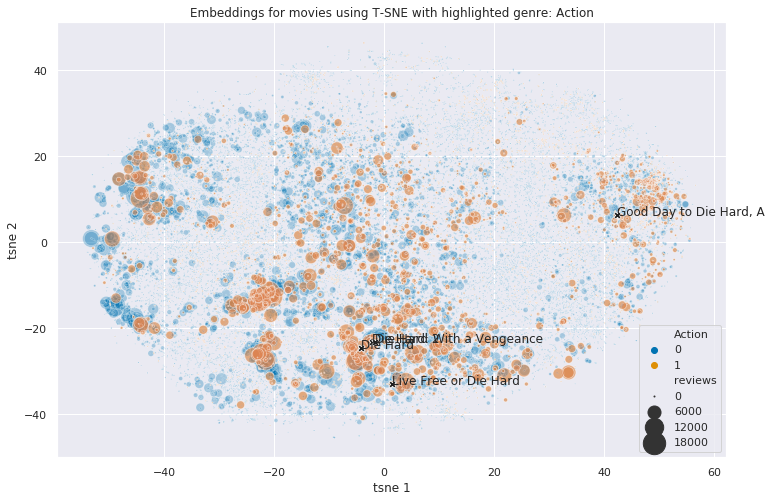

In [561]:
def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x']+.05, point['y'], str(point['val']))

movie = 'Die Hard'
data = movie_emb
data_movie = data[data['title'].str.contains(movie)]
genre = 'Action'

plt.figure(figsize=(12,8))
sns.set_style("darkgrid")
ax =sns.scatterplot(x="tsne 1", y="tsne 2",
              hue=genre,
              data=data, alpha = 0.3,
                  palette=('colorblind'), size = "reviews", sizes = (1, 500), legend = 'brief')
ax1 =sns.scatterplot(x="tsne 1", y="tsne 2",
                  data=data[data[genre]==1], alpha = 0.5,
                  palette=('colorblind'), size = "reviews", sizes = (1, 500), legend = False)
ax2 =sns.scatterplot(x="tsne 1", y="tsne 2",
                  data=data_movie, alpha = 1,
                  color = 'k', marker ='X', s = 50, legend = False)


label_point(data_movie['tsne 1'], data_movie['tsne 2'], data_movie['title'], ax2)  

plt.title("Embeddings for movies using T-SNE with highlighted genre: "+ genre);

## Comparación de modelos

In [ ]:
import seaborn as sns

In [ ]:
plt.figure(figsize=(25,5))
sns.set(font_scale=1.3)
sns.set_style("darkgrid")
plt.ylim(0.67, 1)
plt.plot(feat_val, label = "Tabular + features")
plt.plot(feat_val_4l, label = "Tabular + features 4 layers")
plt.plot(feat_val_4l_wd, label = "Tabular + features 4 layers with WD") # lr slice(5E-05) bs = 64
plt.plot(feat_val_5l, label = "Tabular + features 5 layers")
plt.plot(small_val, label = "Collaborative filtering") # bs = 100
plt.plot(tab_val, label = "Tabular simple")
plt.title("Validation Loss for different Models")
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(25,5))
sns.set(font_scale=1.3)
sns.set_style("darkgrid");
g1 = sns.lineplot(x='date', y='counter', data = data[data['event']=='convertion'], label = 'Total convertions (sin bts)', ci=None)
g2 = sns.lineplot(x='date', y='counter', data = dataf[dataf['event']=='convertion'], label = 'Convertions 3 1 Recommender', ci=None)
plt.xticks(rotation=50);
plt.ticklabel_format(style='plain', axis='y',useOffset=False)
days = data.sort_values(by=['date'])['date'].unique()
daysf = data.sort_values(by=['date'])['date'].unique()
if len(days)>1 : 
    g1.set(xticks=days[0:len(days):step]);
    g2.set(xticks=daysf[0:len(daysf):step]);
g1.axes.set_title(c,fontsize=20)

### De aca para abajo no hay que prestarle atención

Otra forma de reordenar los datos es usando el topk que viene con torch

In [ ]:
b,a = torch.topk(x.view(-1),10)
[(PELIS[i],round(n,2) ) for i,n in zip(a.tolist(),b.tolist()) ]

Ejemplo de module de pytorch que toma dos embeddings de avisos de casas y un embedding de avisos de usuario y los pasa por una capa lineal

In [ ]:
class MiMo(nn.Module):     
    def __init__(self, D_in=15, H=5, D_out=10):
        
        super(MiMo, self).__init__()
        self.casa1 = learn_small.model.embeds[0]
        self.casa2 = learn_small.model.embeds[0]
        self.usuario = learn_small.model.embeds[1]
        self.densa = nn.Linear(300,1)
    
    def forward(self, x):
        # Se asume que la estructura del input de entrada (x) es un tensor de vectores de (al menos) 3 coordenadas
        # La primer y segunda coordenadas son ids de casa y la tercera es un id de usuario
        x = torch.cat([self.casa1(x[:,0]),self.casa2(x[:,1]),self.usuario(x[:,2])],dim=1)        
        #x = torch.cat([x,features])   #Puedo pedir que agregue features al embedding antes de pasarlo por la capa lineal
        return self.densa(x)
        #return 1

In [ ]:
torch.LongTensor([[0,1,2], [3,4,5]])[:,0]

In [ ]:
x = MiMo()
x(torch.LongTensor([[0,1,2]]))

# Pytorch NN

#### Aca hay algunas pruebas con una red de pytorch

In [ ]:
import torch
import torch.nn as nn

In [ ]:
# Defining input size, hidden layer size, output size and batch size respectively
n_in, n_h, n_out, batch_size = 10, 5, 1, 10

In [ ]:
# Create dummy input and target tensors (data)
# Creo un tensor formado por 10 (batch_size) vectores de tamaño 10 (n_in)
x = torch.randn(batch_size, n_in)

In [ ]:
# Y creo la salida esperada para cada uno de esos vectores
y = torch.tensor([[1.0], [0.0], [0.0], 
[1.0], [1.0], [1.0], [0.0], [0.0], [1.0], [1.0]])

In [ ]:
# Create a model
# nn.Sequential crea una sequencia de modulos (o capas). En este caso armamos una que tenga
# Una capa lineal, una Relu, una lineal y una Sigmoid
model = nn.Sequential(nn.Linear(n_in, n_h),
   nn.ReLU(),
   nn.Linear(n_h, n_out),
   nn.Sigmoid())

In [ ]:
model

In [ ]:
# Defino la función de pérdida
criterion = torch.nn.MSELoss()
# Construct the optimizer (Stochastic Gradient Descent in this case)
optimizer = torch.optim.SGD(model.parameters(), lr = 0.01)

In [ ]:
# Gradient Descent
for epoch in range(50):
   # Forward pass: Compute predicted y by passing x to the model
   y_pred = model(x)

   # Compute and print loss
   loss = criterion(y_pred, y)
   #print('epoch: ', epoch,' loss: ', loss.item())

   # Zero gradients, perform a backward pass, and update the weights.
   optimizer.zero_grad()

   # perform a backward pass (backpropagation)
   loss.backward()

   # Update the parameters
   optimizer.step()

print(y_pred)
print(y)

In [ ]:
import os
import numpy as np # linear algebra
import pandas as pd 
from scipy import sparse
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import SparseAdam,Adam,Adagrad,SGD
#from livelossplot import PlotLosses

In [ ]:
path = '/home/fvadell/trabajo/recs/ml-latest-small'

In [ ]:
ratings = pd.read_csv(path+'/ratings.csv')
ratings['y'] = ratings.rating.apply(str)
ratings['user'] = ratings['userId'].apply(lambda x:str(int(x))).astype('category')
ratings['item'] = ratings['movieId'].apply(lambda x:str(int(x))).astype('category')
ratings.head()

In [ ]:
# Creo train y test sets
train, test = train_test_split(ratings, test_size=0.2)

In [ ]:
test.head()

In [ ]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(100, 30)
        self.fc2 = nn.Linear(30, 50)
        self.fc3 = nn.Linear(50, 1)

    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features


net = Net()
print(net)

In [ ]:
x = torch.randn(5,100)

In [ ]:
x

In [ ]:
net = Net()

In [ ]:
x = torch.Tensor(x)

In [ ]:
x.shape

In [ ]:
net.forward(x)

In [ ]:
params = list(net.parameters())

In [ ]:
# Hay 2 sets de parámetros por cada capa porque las capas Lineales tienen tanto Weights como Bias.
# Si seteara bias=False cuando se llama a nn.Linear entonces tendría 3 sets de parámetros
len(params)

In [ ]:
model = nn.Sequential(Net())

In [ ]:
model

In [ ]:
# Defino la función de pérdida
criterion = torch.nn.MSELoss()
# Construct the optimizer (Stochastic Gradient Descent in this case)
optimizer = torch.optim.SGD(model.parameters(), lr = 0.01)

In [ ]:
x

In [ ]:
model(x).shape

In [ ]:
y = torch.Tensor([1,0.2,0.7,0.1,0])

In [ ]:
y.shape

In [ ]:
y.resize_((5,1))
y.shape

In [ ]:
# Gradient Descent
for epoch in range(50):
   # Forward pass: Compute predicted y by passing x to the model
   y_pred = model(x)

   # Compute and print loss
   loss = criterion(y_pred, y)
   #print('epoch: ', epoch,' loss: ', loss.item())

   # Zero gradients, perform a backward pass, and update the weights.
   optimizer.zero_grad()

   # perform a backward pass (backpropagation)
   loss.backward()

   # Update the parameters
   optimizer.step()

print(y_pred)
print(y)